<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/instance_segmentation_with_yolov8_20230629.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Instance Segmentation with YOLOv8
Source: https://www.kaggle.com/code/mersico/medical-instance-segmentation-with-yolov8 <br>

Python wheels: https://realpython.com/python-wheels/<br>
https://www.geeksforgeeks.org/what-is-a-python-wheel/<br>

Yolov8 with colab: https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb#scrollTo=7mGmQbAO5pQb


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #b5e1ff; font-family:verdana; color: #011d82; border: 2px #011d82 solid">
    <b>What is instance segmentation?</b>
    <br>Instance Segmentation is a unique form of image segmentation that deals with detecting and delineating each distinct instance of an object appearing in an image. Instance segmentation detects all instances of a class with the extra functionality of demarcating separate instances of any segment class. Hence, it is also referred to as incorporating object detection and semantic segmentation functionality. Watch video to learn more: <a href=instance segmentation>Instance segmentation | Tutorial</a> <br>
</div>

# Prepare data
<div class="alert alert-block alert-info" style="font-size:20px; background-color: #abffd1; font-family:verdana; color: #003819; border: 2px #003819 solid">
    <b>It's time to think about data 📚</b>
    <br>For training, we need a dataset, and not just any, but in the COCO format. COCO is an open database for object detection, it is huge and therefore it is used all over the world to evaluate new models according to various metrics. It plays a rather important role, and most detection models are pre-trained on it. That is why this dataset format is used in <b>ultralytics</b>. You don't need to worry about this, as I have already prepared a class for data processing. I advise you to skip the cell below and immediately proceed to the next chapter.<br>
</div>

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_grey_bkgrnd	    test	    val_list.csv
images		     masks_white_bkgrnd     test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [3]:
!nvidia-smi

Thu Jul  6 20:22:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install colorama

In [5]:
# libraries needed to create the create the dataset in COCO format
from itertools import chain
import json
import os
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np

In [6]:
# class for creating the dataset
class COCODataset:
    def __init__(self, images_dirpath: str, annotations_filepath: str, length: int = 1633):
        self.train_size = None
        self.val_size = None
        self.length = length
        self.classes = None
        self.labels_counter = None
        self.normalize = None

        self.images_dirpath = images_dirpath
        self.annotations_filepath = annotations_filepath
        self.dataset_dirpath = os.path.join(os.getcwd(), "dataset")
        self.train_dirpath =  os.path.join(self.dataset_dirpath, "train")
        self.val_dirpath =  os.path.join(self.dataset_dirpath, "val")
        self.config_path = os.path.join(self.dataset_dirpath, "coco.yaml")

        self.samples = self.parse_jsonl(annotations_filepath)
        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

    def __prepare_dirs(self) -> None:
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.train_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.train_dirpath, "labels"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.val_dirpath, "labels"), exist_ok=True)
        else:
            raise RuntimeError("Dataset already exists!")

    def __define_splitratio(self) -> None:
        self.train_size = round(self.length * self.train_size)
        self.val_size = self.length - self.train_size
        assert self.train_size + self.val_size == self.length

    def parse_jsonl(self, path: str) -> list[dict, ...]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons", total=self.length
                )
            ]
        return jsonl_samples

    def __define_paths(self, i: int) -> dict:
        data_path = self.val_dirpath
        if i < self.train_size:
            data_path = self.train_dirpath
        return {
            "images": os.path.join(data_path, "images"),
            "labels": os.path.join(data_path, "labels")
        }

    @staticmethod
    def __get_label_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["labels"],
            f"{identifier}.txt"
        )

    @staticmethod
    def __get_image_path(paths_dict: dict, identifier: str) -> str:
        return os.path.join(
            paths_dict["images"],
            f"{identifier}.tif"
        )

    def __copy_image(self, dst_path: str, identifier: str) -> str:
        shutil.copyfile(
            os.path.join(self.images_dirpath, f"{identifier}.tif"),
            dst_path
        )

    def __copy_label(self, annotations: list, dst_path: str) -> None:
        with open(dst_path, "w") as file:
            for annotation in annotations:
                coordinates = annotation["coordinates"][0]
                label = self.classes_dict[annotation["type"]]
                if label in self.classes:
                    if coordinates:
                        if self.normalize:
                            coordinates = np.array(coordinates) / 512.0
                        coordinates = " ".join(map(str, chain(*coordinates)))
                        file.write(f"{label} {coordinates}\n")
                        self.labels_counter += 1

    def __splitfolders(self):
        for i, line in tqdm(
                enumerate(self.samples),
                desc="Dataset creation", total=self.length
        ):
            self.labels_counter = 0
            identifier = line["id"]
            annotations = line["annotations"]
            paths_dict = self.__define_paths(i)

            dst_image_path = self.__get_image_path(paths_dict, identifier)
            dst_label_path = self.__get_label_path(paths_dict, identifier)

            self.__copy_image(dst_image_path, identifier)
            self.__copy_label(annotations, dst_label_path)

            if self.labels_counter == 0:
                os.remove(dst_image_path)
                os.remove(dst_label_path)

    def __count_dataset(self) -> dict:
        train_images = len(os.listdir(os.path.join(self.train_dirpath, "images")))
        train_labels = len(os.listdir(os.path.join(self.train_dirpath, "labels")))
        val_images = len(os.listdir(os.path.join(self.val_dirpath, "images")))
        val_labels = len(os.listdir(os.path.join(self.val_dirpath, "labels")))
        return {
            "train_images": train_images,
            "train_labels": train_labels,
            "val_images": val_images,
            "val_labels": val_labels
        }

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["train_images"] == count_dict["train_labels"]
        assert count_dict["val_images"] == count_dict["val_labels"]

    def __finalizing(self, count_dict: dict) -> None:
        assert os.path.exists(self.dataset_dirpath)

        example_structure = [
            "dataset",
            "train", "labels", "images",
            "val", "labels", "images"
        ]

        dir_bone = (
            dirname.split("/")[-1]
            for dirname, _, filenames in os.walk(self.dataset_dirpath)
            if dirname.split("/")[-1] in example_structure
        )

        try:
            print("\n~ HuBMAP Dataset Structure ~\n")
            print(
            f"""
          ├── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │
          │   ├── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
          │   │   └── {next(dir_bone)}
            """
            )
        except StopIteration as e:
            print(e)
        else:
            print(Fore.GREEN + "-> Success")
            print(Fore.GREEN + f"Train dataset: {count_dict['train_images']}\nVal dataset: {count_dict['val_images']}")

    def get_config(self) ->dict:
        names = ["blood_vessel", "glomerulus", "unsure"]
        return {
            "train": str(self.train_dirpath),
            "val": str(self.val_dirpath),
            "names": [names[i] for i in self.classes]
        }

    @staticmethod
    def display_config(config: dict) -> None:
        print(Fore.BLACK + "\n~ HuBMAP Config Structure ~\n")
        print(
        f"""
      │   │
      │   ├── train
      │   │   └── {config['train']}/images
      │   │
      │   │
      │   ├── val
      │   │   └── {config['val']}/images
      │   │
      │   │
      │   ├── names
      │   │   └── {' '.join(config['names'])}
        """
        )
        print(Fore.GREEN + "-> Success")
        print(Fore.GREEN + f"Number of classes: {len(config['names'])}"
                           f"\nClasses: {' '.join(config['names'])}"
              )

    def write_config(self, config: dict) -> None:
        with open(self.config_path, mode="w") as f:
            yaml.safe_dump(stream=f, data=config)

    def __call__(self, train_size: float,
                 classes: list[int, ...],
                 make_config: bool = True,
                 normalize: bool = True
                ) -> None:

        self.train_size = train_size
        self.classes = classes
        self.normalize = normalize

        self.__define_splitratio()
        self.__prepare_dirs()
        self.__splitfolders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.__finalizing(count_dict)

        if make_config:
            config = self.get_config()
            self.write_config(config)
            self.display_config(config)

In [7]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_grey_bkgrnd	    test	    val_list.csv
images		     masks_white_bkgrnd     test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [8]:
# instantiate a COCODataset object
path = '/gdrive/MyDrive/DATA/HuBMAP/'
coco = COCODataset(
    annotations_filepath= path + 'polygons.jsonl',
    images_dirpath=path + 'images'
)

Processing polygons:   0%|          | 0/1633 [00:00<?, ?it/s]

In [9]:
coco(train_size=0.80, classes=[0, 1, 2])

Dataset creation:   0%|          | 0/1633 [00:00<?, ?it/s]


~ HuBMAP Dataset Structure ~


          ├── dataset
          │   │
          │   ├── val
          │   │   └── images
          │   │   └── labels
          │   │
          │   ├── train
          │   │   └── images
          │   │   └── labels
            
-> Success
Train dataset: 1306
Val dataset: 327

~ HuBMAP Config Structure ~


      │   │
      │   ├── train
      │   │   └── /content/dataset/train/images
      │   │
      │   │
      │   ├── val
      │   │   └── /content/dataset/val/images
      │   │
      │   │
      │   ├── names
      │   │   └── blood_vessel glomerulus unsure
        
-> Success
Number of classes: 3
Classes: blood_vessel glomerulus unsure


In [10]:
!ls dataset

coco.yaml  train  val


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #f2ffb0; font-family:verdana; color: #3c450e; border: 2px #3c450e solid">
    <b>And how can I use the right tools if the internet is banned in the competition? 🙁</b>
    <br>In the competition, many have difficulty installing the necessary tools and using them, because the Internet is prohibited, but it is prohibited only so that the test data is not stolen (they are uploaded to the test folder during the submission of the result). This means that you can use the tools you want, but you must add them as data. You can find my <b>ultralytics</b> and <b>pycocotools</b> dataset here. Importantly, the Internet is still present in this notebook to load the model, however, after training it, you will save the model, add it to the data and easily use it for forecasting without the Internet.<br>
</div>

In [11]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.9/625.9 kB 9.1 MB/s eta 0:00:00


In [12]:
!pip show ultralytics

Name: ultralytics
Version: 8.0.128
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, Pillow, psutil, PyYAML, requests, scipy, seaborn, torch, torchvision, tqdm
Required-by: 


In [13]:
!mkdir ultralytics_wheels
%cd ultralytics_wheels
!pip wheel ultralytics

/content/ultralytics_wheels
  Using cached ultralytics-8.0.128-py3-none-any.whl (625 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 108.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [14]:
%cd ..

/content


In [36]:
!ls

NotImplementedError: ignored

In [ ]:
# list of all packages installed in your system
# !pip list

In [16]:
!pip install pycocotools

In [17]:
!pip show pycocotools

Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [18]:
!mkdir pycocotools_wheels
%cd pycocotools_wheels
!pip wheel pycocotools

/content/pycocotools_wheels
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Using cached contourpy-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.40.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.2 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached Pillow-10.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached six-1.16.0-py2.p

In [19]:
%cd ..

/content


In [20]:
!ls

dataset  pycocotools_wheels  sample_data  ultralytics_wheels


In [ ]:
!pip install --no-index --no-deps /content/pycocotools_wheels/*
import pycocotools
!pip show pycocotools


Processing ./pycocotools_wheels/contourpy-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./pycocotools_wheels/cycler-0.11.0-py3-none-any.whl
Processing ./pycocotools_wheels/fonttools-4.40.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./pycocotools_wheels/kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Processing ./pycocotools_wheels/matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./pycocotools_wheels/numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./pycocotools_wheels/packaging-23.1-py3-none-any.whl
Processing ./pycocotools_wheels/Pillow-10.0.0-cp310-cp310-manylinux_2_28_x86_64.whl
Processing ./pycocotools_wheels/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
Processing ./pycocotools_wheels/pyparsing-3.1.0-py3-none-any.whl
Processing ./pycocotools_wheels/python_dateutil-2.8.2-py2.py3-none-any.whl
Processing ./pycocotools_wheels/six

Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [ ]:
!pip install --no-index --no-deps /content/ultralytics_wheels/*
import ultralytics
!pip show ultralytics

Processing ./ultralytics_wheels/certifi-2023.5.7-py3-none-any.whl
Processing ./ultralytics_wheels/charset_normalizer-3.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./ultralytics_wheels/cmake-3.26.4-py2.py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
Processing ./ultralytics_wheels/contourpy-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./ultralytics_wheels/cycler-0.11.0-py3-none-any.whl
Processing ./ultralytics_wheels/filelock-3.12.2-py3-none-any.whl
Processing ./ultralytics_wheels/fonttools-4.40.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./ultralytics_wheels/idna-3.4-py3-none-any.whl
Processing ./ultralytics_wheels/Jinja2-3.1.2-py3-none-any.whl
Processing ./ultralytics_wheels/kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
Processing ./ultralytics_wheels/lit-16.0.6-py3-none-any.whl
Processing ./ultralytics_wheels/MarkupSafe-2.1.3-cp310-cp310-manylinux_2_17_x86_64

ImportError: ignored

NameError: ignored

In [21]:
# Add libraries for
import shutil
import os
import sys
from colorama import Fore

In [22]:
class SetupPipline:
    def __init__(self, display: bool = True):
        self.pycocotools = self.__pycocotools()
        self.ultralytics = self.__ultralytics()

    @staticmethod
    def __ultralytics() -> str:
        sys.path.append("/content/ultralytics_wheels/ultralytics")
        return "successfully"

    @staticmethod
    def __pycocotools() -> str:
        if not os.path.exists("/content/packages"):
            shutil.copytree("/content/pycocotools_wheels", "/content/packages")
            os.chdir("/content/packages/")
            os.system("python setup.py install")
            os.system("pip install . --no-index --find-links /conetent/packages/")
            os.chdir("/content")
            return "successfully"

    def display(self) -> None:
        print(Fore.GREEN+f"\nPycocotools was installed {self.pycocotools}")
        print(f"Ultralytics was installed {self.ultralytics}"+Fore.WHITE)

In [23]:
pipline = SetupPipline()

creating and copying to directory: /content/packages


In [24]:
pipline.display()


Pycocotools was installed successfully
Ultralytics was installed successfully


In [25]:
from pycocotools import _mask as coco_mask
import ultralytics
from ultralytics import YOLO

In [26]:
ultralytics.checks()

Ultralytics YOLOv8.0.128 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 30.9/166.8 GB disk)


In [27]:
!nvidia-smi

Thu Jul  6 20:50:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Train reference
# https://docs.ultralytics.com/modes/train/

In [28]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/content/dataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=20,
        batch=4,
        workers=8,
        val=True,
        device= 0,

        # Optimization parameters
        lr0=0.018,
        patience=3,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.0005,
        close_mosaic=3,
    )

In [29]:
if __name__ == '__main__':
    main()


100%|██████████| 137M/137M [00:04<00:00, 35.8MB/s]
Ultralytics YOLOv8.0.128 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/content/dataset/coco.yaml, epochs=20, patience=3, batch=4, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=to

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

In [41]:
dirlist = os.listdir("/content/dataset/val/images")
print(dirlist[:5])

['e63d156bc72f.tif', 'd4a6a9e8d85e.tif', 'eb7564c1ca68.tif', 'd6d79e965902.tif', 'e56a225520aa.tif']



image 1/1 /content/dataset/val/images/ed6a92a9410c.tif: 512x512 7 blood_vessels, 1 unsure, 69.3ms
Speed: 1.7ms preprocess, 69.3ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 512)


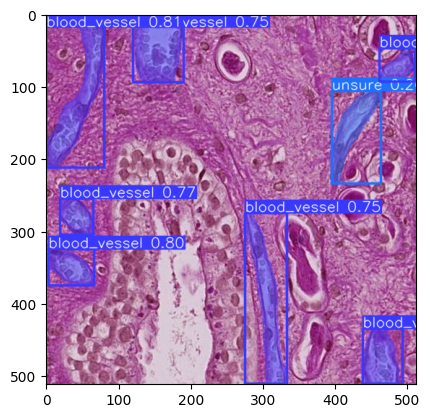

In [44]:
model = YOLO("/content/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("/content/dataset/val/images/ed6a92a9410c.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

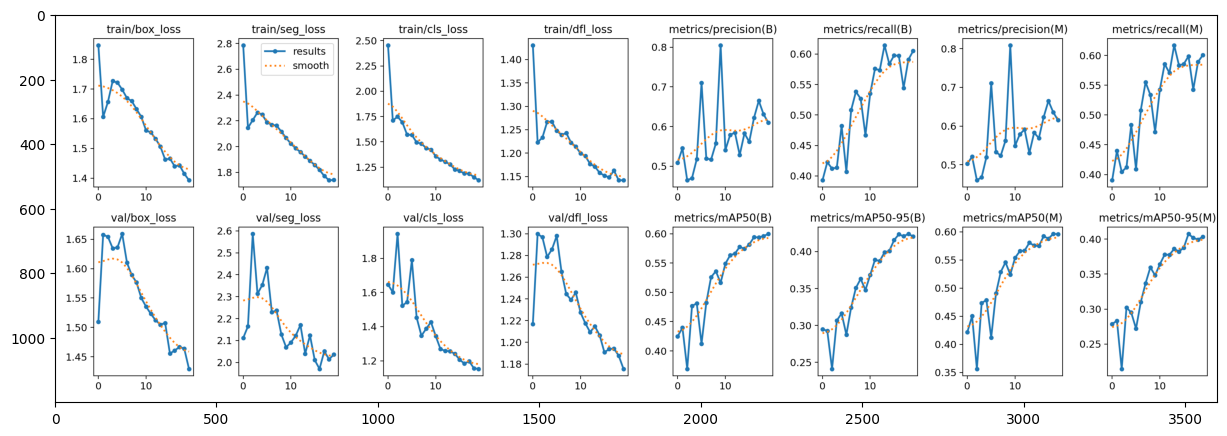

In [45]:
F1_curve = Image.open("/content/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()


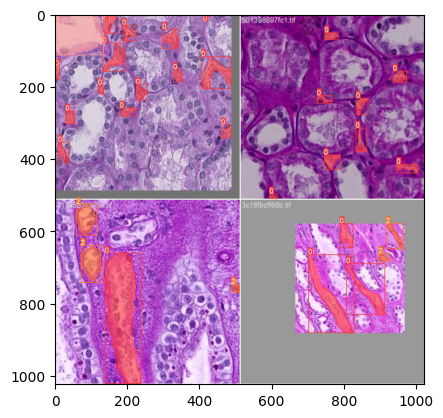

In [46]:
P_curve = Image.open("/content/HuBMAP/yolov8x-seg/train_batch5561.jpg")
plt.imshow(P_curve)
plt.show()